In [1]:
from glob import glob
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from mycolorpy import colorlist as mcp
import contextily as cx
from loguru import logger
from tqdm import tqdm
from glob import glob
import re
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from unidecode import unidecode
from rich.jupyter import print
from rich.console import Console
from rich.table import Table
from pathlib import Path
from multiprocessing import Pool
from matplotlib.backends.backend_pdf import PdfPages
from shapely.geometry import box
from shapely.geometry import Polygon, MultiPolygon, shape, Point
from matplotlib_scalebar.scalebar import ScaleBar
files = list(Path('./').rglob('*.gpkg'))+list(Path('./').rglob('*.shp'))+list(Path('./').rglob('*.zip'))

In [2]:
def bound_box_buffer(tmp_df):
    tmp = gpd.GeoDataFrame([{'geometry':box(*tmp_df.total_bounds)}],crs=3857)
    falta = (((5*10_000 - tmp.area) ** 0.5)/2 ) 
    if falta[0] > 0:
        tmp = tmp.buffer(falta)
    return tmp

def normalize(s):
    try:
        return unidecode(s.lower()).replace('\r','').rstrip()
    except:
        return s
    
colides_col = ['intersects', 'covers', 'within', 'touches', 'geom_equals_exact', 'error']    
    
def is_vazio(data):
    if len(data) ==0:
        return np.nan
    return data

def area_cat(area):
    if area < 0.001:
        return '< 0.001'
    elif area >= 0.001 and area < 0.5:
        return '0.001 - 0.5'
    elif area >= 0.5 and area < 1:
        return '0.5 - 1'
    elif area >= 1 and area < 2:
        return '1 - 2'
    elif area >= 2 and area < 4:
        return '2 - 4'
    elif area >= 4 and area < 8:
        return '4 - 8'
    elif area >= 8 and area < 10:
        return '8 - 10'
    elif area >= 10 and area < 20:
        return '10 - 20'
    elif area >= 20 and area < 30:
        return '20 - 30'
    elif area >= 30 and area < 40:
        return '30 - 40'
    elif area >= 40 and area < 50:
        return '40 - 50'
    elif area >= 50 and area < 100:
        return '50 - 100'
    elif area >= 100 and area < 150:
        return '100 - 150'
    elif area >= 150 and area < 300:
        return '150 - 300'
    elif area >= 300 and area < 450:
        return '300 - 450'
    elif area >= 450 and area < 600:
        return '450 - 600'
    elif area >= 600 and area < 750:
        return '600 - 750'
    elif area >= 750 and area < 900:
        return '750 - 900'
    elif area >= 900 and area < 1000:
        return '900 - 1000'
    elif area >= 1000 and area < 2000:
        return '1000 - 2000'
    elif area > 2000:
        return '> 2000'

def get_colides_by_id(_id):
    test = all_df[all_df['index'] != _id]
    try:
        return {
            'index':_id,
            'file':all_df.iloc[_id]['file'],
            'intersects': is_vazio(set(test[test.intersects(all_df.iloc[_id].geometry)]['index'])),
            'covers': is_vazio(set(test[test.covers(all_df.iloc[_id].geometry)]['index'])),
            'within': is_vazio(set(test[test.within(all_df.iloc[_id].geometry)]['index'])),
            'touches': is_vazio(set(test[test.touches(all_df.iloc[_id].geometry)]['index'])),
            'geom_equals_exact': is_vazio(set(test[test.geom_equals_exact(all_df.iloc[_id].geometry,tolerance=0.00001)]['index'])),
            'geometry':all_df.iloc[_id]['geometry']

        }
    except Exception as e:
        return {
            'index':_id,
            'file':all_df.iloc[_id]['file'],
            'geometry':all_df.iloc[_id]['geometry'],
            'error':e
        }    
    

    
cat_area_name = [
'< 0.001', '0.001 - 0.5', '0.5 - 1', '1 - 2', '2 - 4', '4 - 8', '8 - 10',
'10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 100', '100 - 150',
'150 - 300', '300 - 450', '450 - 600', '600 - 750', '750 - 900', 
'900 - 1000', '1000 - 2000', '> 2000'
]


def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p is None:
            new_geo.append(p)
        elif p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                #print(dir(p))
                for ap in p.geoms:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
            else:
                print('ops')
        else:
            new_geo.append(p)
    return new_geo

area_ordenada = pd.CategoricalDtype(categories=cat_area_name, ordered=True)

In [3]:
df = gpd.read_file('Beraca (REVISAR)/beraca_restauracao.shp').to_crs(4326)



In [ ]:
metadata = []
geo_data = []
for file in sorted(files):
    try:
        tmp = gpd.read_file(file)
        _metadata = {
            'file': file,
            'columns':sorted([normalize(i) for i in tmp.columns]),
            'len_columns':len(tmp.columns),
            'len':len(tmp)
        }
        path = file.name.split('.')[0]
        
        text_area = ''
        
        df_wm = tmp.to_crs(epsg=3857)
        
        if any(df_wm.geometry.has_z):
            df_wm.geometry = convert_3D_2D(df_wm.geometry)
            print('3d to 2d')
        
        df_wm['area_ha'] = df_wm.to_crs(5880).area / 10_000 

        df_wm['area_cat'] = df_wm['area_ha'].apply(area_cat).astype(area_ordenada)
        df_wm['file'] = file
        araea_size =df_wm.groupby('area_cat', observed=True).size()
        
        
        df_wm = df_wm.dropna(subset=['geometry']).copy()
        
        df_wm['index'] = df_wm.reset_index().index
        df_wm=df_wm.reset_index()
        
        print(f"calculando colisao {file}")
        def interna(_id):
            test = df_wm[df_wm['index'] != _id]
            try:
                return {
                    'index':_id,
                    #'file':str(df_wm.iloc[_id]['file']),
                    'intersects': is_vazio(set(test[test.intersects(df_wm.iloc[_id].geometry)]['index'])),
                    'covers': is_vazio(set(test[test.covers(df_wm.iloc[_id].geometry)]['index'])),
                    'within': is_vazio(set(test[test.within(df_wm.iloc[_id].geometry)]['index'])),
                    'touches': is_vazio(set(test[test.touches(df_wm.iloc[_id].geometry)]['index'])),
                    'geom_equals_exact': is_vazio(set(test[test.geom_equals_exact(df_wm.iloc[_id].geometry,tolerance=0.00001)]['index'])),
                    'error':np.nan
                    #'geometry':df_wm.iloc[_id]['geometry']

                }
            except Exception as e:
                return {
                    #'index':_id,
                    'file':str(df_wm.iloc[_id]['file']),
                    #'geometry':df_wm.iloc[_id]['geometry'],
                    'error':str(e)
                }
    
        
        with Pool(16) as works:
            rows = list(
                tqdm(
                    works.imap_unordered(
                        interna, df_wm['index']), total=len(df_wm['index'])))

        inter_colides = pd.DataFrame(rows).dropna(subset=colides_col,how='all').sort_values('index').set_index('index')
        inter_colides.to_csv(f"csv/{str(file).replace('/', ' | ')}.csv")
        
        df_wm['value'] = 1
        df_wm.geometry = df_wm.geometry.make_valid()
        dr_dissolve_areaa = df_wm.dissolve('area_cat', observed=True).to_crs(5880).area / 10_000
        total_area = df_wm.dissolve('value').to_crs(5880).area / 10_000
        
        area_ha_df =pd.DataFrame({'quantidae':araea_size,'total ha':dr_dissolve_areaa})
        area_ha_df['total ha'].sum() ==  total_area.sum()
        geo_data.append(df_wm[['area_ha','area_cat', 'file','geometry']])
        with PdfPages(f'pdf/{str(file).replace("/","|")}.pdf') as pdf:
            fig, ax = plt.subplots()
            coluns_txt = ''
            for c in tmp.columns:
                coluns_txt += f'  - {c}\n'
            ax.axis('off')  # Desliga os eixos do gráfico
            markdown_text = f"""
Relatoria do arquivo: {file}
Soma da area do poligino em hectares = {total_area.sum()}

colunas:
{coluns_txt}

            """

            ax.text(0.1, 0.9, markdown_text, fontsize=12, ha='left', va='top', transform=fig.transFigure)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
            
            
            fig, ax = plt.subplots()
            ax.axis('off') 
            table = pd.plotting.table(ax, area_ha_df, loc='top',
                          cellLoc='center')
            pdf.savefig(fig, bbox_inches='tight')
            
            plt.close()
            
            
            fig, ax = plt.subplots()
            plt.title('Categoria de area em hectares')
            araea_size.plot.barh()
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()
            
            for col in tmp.columns:
                if not col == 'geometry':
                    data = tmp.groupby(col).size()
                    if len(data) < 50 and len(data) > 0:
                        try:
                            fig, ax = plt.subplots(figsize=(6,len(data)))
                            Path(f'figs/{path}').mkdir(exist_ok=True)
                            plt.title(f'{col} - {path}')
                            data.plot.barh(ax=ax)
                            pdf.savefig(fig, bbox_inches='tight')
                            plt.close()
                        except Exception as e:
                            print(e)
            
            print('geometry')
            df_wm.sort_values('area_ha',inplace=True)
            fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(10, 30))
            df_wm.plot(figsize=(10, 10), color='red', edgecolor="red", linewidth=3, ax=ax1)
            cx.add_basemap(ax1,source='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}')
            ax1.add_artist(ScaleBar(1))
            ax1.set_title(f"{file} contem {len(df_wm)} geometrias")
            ax2.set_title(f"{file} menor {df_wm.iloc[0]['area_ha']:.9f} ha")
            ax3.set_title(f"{file} maior {df_wm.iloc[-1]['area_ha']:.3f} ha")

            df_wm.iloc[:1].boundary.plot(figsize=(10, 10), alpha=1, linewidth=3, edgecolor="red",ax=ax2)
            bound_box_buffer(df_wm.iloc[:1]).plot(alpha=0.0, ax=ax2)
            cx.add_basemap(ax2,source='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}')
            ax2.add_artist(ScaleBar(1))
            ax3.set_title(f"{file} maior {df_wm.iloc[-1]['area_ha']:.3f} ha")
            df_wm.iloc[-1:].boundary.plot(figsize=(10, 10), alpha=1, linewidth=3, edgecolor="red",ax=ax3)
            bound_box_buffer(df_wm.iloc[-1:]).plot(alpha=0.0, ax=ax3 )
            cx.add_basemap(ax3,source='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}')
            ax3.add_artist(ScaleBar(1))
            pdf.savefig(fig, bbox_inches='tight')
            
            # plt.show()
            plt.close()
            
            for i, row in df_wm[df_wm['area_cat'] == '< 0.001'].iterrows():
                fig, ax = plt.subplots(figsize=(16,16))
                row_ = gpd.GeoDataFrame([row])
                ax.set_title(f"{file} {row['area_ha']:.8f} ha")
                row_.boundary.plot(figsize=(10, 10), alpha=1, linewidth=3, edgecolor="red",ax=ax)
                bound_box_buffer(row_).plot(alpha=0.0, ax=ax )
                cx.add_basemap(ax,source='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}')
                ax.add_artist(ScaleBar(1))
                
                pdf.savefig(fig, bbox_inches='tight')
                # plt.show()
                plt.close()
                
        metadata.append(_metadata)
    except Exception as e:
        logger.exception(e)
        metadata.append({
            'file': file,
            'columns':[],
            'len_columns':0,
            'error':e
        }
        )



calculando colisao Alianca (REVISAR)/alianca_restauracao.shp

100%|██████████| 21/21 [00:00<00:00, 1352.05it/s]


geometry

calculando colisao Araticum/Araticum_ORR.shp

100%|██████████| 135/135 [00:00<00:00, 6518.74it/s]


geometry

3d to 2d

calculando colisao Beraca (REVISAR)/beraca_restauracao.shp

100%|██████████| 64/64 [00:00<00:00, 1943.24it/s]


geometry

3d to 2d

calculando colisao Black Jaguar/BlackJaguar_Areas.shp

100%|██████████| 236/236 [00:00<00:00, 2723.58it/s]


geometry

calculando colisao BrCarbon/EMAS_ORR.shp

100%|██████████| 21/21 [00:00<00:00, 1092.02it/s]


geometry

calculando colisao BrCarbon/Pratigi_Pai1_ORR.shp

100%|██████████| 53/53 [00:00<00:00, 1967.15it/s]


geometry

3d to 2d

calculando colisao BrCarbon/Pratigi_Pai2_ORR.shp

100%|██████████| 159/159 [00:00<00:00, 2475.91it/s]


geometry

calculando colisao CEVP/Restauracao_CEVP.shp

100%|██████████| 333/333 [00:00<00:00, 2855.50it/s]


geometry

3d to 2d

calculando colisao ECOPORE/FLONA BOM FUTURO/FLONA-Bom_Futuro.shp

100%|██████████| 3/3 [00:00<00:00, 345.83it/s]
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')


geometry

3d to 2d

calculando colisao ECOPORE/NFNC/Todos_Poligonos_NFNC.shp

100%|██████████| 422/422 [00:00<00:00, 2970.78it/s]


geometry

3d to 2d

calculando colisao ECOPORE/Viveiro Cidadão 2019/16_RADS_JOVENS_VIVEIRO_CIDADAO.shp

100%|██████████| 21/21 [00:00<00:00, 1108.42it/s]


geometry

3d to 2d

calculando colisao ECOPORE/Viveiro Cidadão 2019/Poligonos_119_RAD_VIVEIRO_CIDADAO.shp

100%|██████████| 181/181 [00:00<00:00, 2725.44it/s]


geometry

3d to 2d

calculando colisao EDEN/EDEN_RESTAURAÇÃO.shp

100%|██████████| 13/13 [00:00<00:00, 805.24it/s]
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')


geometry

calculando colisao ICRAF (REVISAR)/ICRAF_AREAS.shp

100%|██████████| 15/15 [00:00<00:00, 1851.90it/s]
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')


geometry

calculando colisao ICV/ICV_restauracao.shp

100%|██████████| 580/580 [00:00<00:00, 2710.99it/s]


geometry

calculando colisao IPE (revisar)/Ipe_ORR.shp

100%|██████████| 38/38 [00:00<00:00, 1805.82it/s]


geometry

calculando colisao Imazon_saf_rna/ORR_Imazon.shp

100%|██████████| 375/375 [00:00<00:00, 2833.42it/s]


geometry

calculando colisao ORR_area_regreen/MA_PAI_001.shp

100%|██████████| 128/128 [00:00<00:00, 2525.32it/s]


geometry

calculando colisao ORR_area_regreen/MA_PAI_002.shp

100%|██████████| 197/197 [00:00<00:00, 321.05it/s]


geometry

3d to 2d

calculando colisao Projetos Kanindé (Revisar ORR)/Dados recebidos/INICIATIVAS_EXECUTADAS_PELA_AGROFLORA.shp

100%|██████████| 6/6 [00:00<00:00, 466.37it/s]


geometry

3d to 2d

calculando colisao Projetos Kanindé (Revisar ORR)/Final/AGF Kaninde pol final.shp

100%|██████████| 6/6 [00:00<00:00, 538.08it/s]


geometry

2024-04-25 20:22:31.405 | ERROR    | __main__:<module>:164 - 'utf-8' codec can't decode byte 0xe2 in position 9: unexpected end of data
Traceback (most recent call last):

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/conda/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
    │   └ <bound method Application.launch_instance of <class 'ipykernel.kernelapp.IPKernelApp'>>
    └ <module 'ipykernel.kernelapp' from '/opt/conda/lib/python3.11/site-packages/ipykernel/kernelapp.py'>
  File "/opt/conda/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
    │   └ <function IPKernelApp.start at 0x7fb9a1ac32e0>
    └ <ipykernel.kernelapp.IPKernelApp object at 0x7fb9a4a08b50>
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
    │    │       └ <function

calculando colisao Reflorestar/Programa Reflorestar/Bacia do Doce.zip

100%|██████████| 3066/3066 [00:01<00:00, 1812.76it/s]


geometry

calculando colisao Reflorestar/Programa Reflorestar/Extenção Ambiental.zip

100%|██████████| 1194/1194 [00:00<00:00, 2499.12it/s]
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')


geometry

calculando colisao Reflorestar/Reflorestar_shapefile/main_reflorestar_2021_revisado.shp

100%|██████████| 11316/11316 [00:35<00:00, 319.10it/s]


geometry

calculando colisao SARE (REVISAR)/SARE_SHAPEFILE/Sare_Sirgas.shp

100%|██████████| 4591/4591 [00:06<00:00, 718.09it/s]


geometry

calculando colisao SARE (REVISAR)/sare.gpkg

100%|██████████| 4591/4591 [00:06<00:00, 679.05it/s]


geometry

calculando colisao Solidaridad/restauramazonia_saf_v06.10.2023_compartilhado.shp

100%|██████████| 345/345 [00:00<00:00, 2874.39it/s]


geometry

calculando colisao TNC/Araucária e Serra do Mar/Araucária e Serra do Mar.zip

100%|██████████| 1541/1541 [00:00<00:00, 1821.28it/s]
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')


geometry

calculando colisao TNC/Coalizão Cidades pelas Águas/Coalizão Cidades pelas Águas.zip

100%|██████████| 283/283 [00:00<00:00, 2891.95it/s]
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')


geometry

calculando colisao TNC/Conservador da Mantiqueira/Conservador da Mantiqueira.zip

100%|██████████| 397/397 [00:00<00:00, 2342.35it/s]
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')


geometry

3d to 2d

calculando colisao UEMA - Revisar/UEMA Rousseau pol final.shp

100%|██████████| 5/5 [00:00<00:00, 428.35it/s]


geometry

3d to 2d

calculando colisao Vale nao ferrosos (revisar)/Valenaoferrosos_ORR.shp

100%|██████████| 150/150 [00:00<00:00, 3862.92it/s]
) missing from current font.0432.py:120: UserWarning: Glyph 13 (
  pdf.savefig(fig, bbox_inches='tight')


geometry

3d to 2d

calculando colisao pacto_organizado/AREAS_RESTAURACAO_PACTO_240124.shp

 69%|██████▉   | 17072/24776 [03:25<02:31, 50.69it/s] 

In [ ]:
all_df = gpd.GeoDataFrame(pd.concat(geo_data),crs=3857).to_crs(4326)
all_df['area_cat'] = all_df['area_cat'].astype(str)
all_df['file'] = all_df['file'].astype(str)
all_df.to_file('../total_gemetry.gpkg')

In [ ]:
all_df['index'] = all_df.reset_index().index
all_df = all_df.reset_index()


In [ ]:
with Pool(processes=16) as work:
    mapped_values = list(tqdm(work.imap_unordered(get_colides_by_id, all_df['index']), total=len(all_df['index'])))


In [ ]:
def to_srt(data):
    try:
        return'|'.join([str(i) for i in data])
    except:
        return np.nan

In [9]:
colides_all = gpd.GeoDataFrame(mapped_values, crs=4326)

In [10]:
colides_all.to_file('../colides.gpkg')

ValueError: Invalid field type <class 'set'>

In [ ]:
colides_all = gpd.read_file('../colides.gpkg')
colides_all

In [ ]:
for i in ['intersects', 'covers', 'within', 'touches', 'geom_equals_exact']:
    colides_all[i] = colides_all[i].apply(to_srt)

In [ ]:
colides_all

In [10]:
df1 = colides_all[['index','file',name_test]]#.dropna(subset=[name_test])
df1[ df1['index'] == 20074 ]

,index,file,intersects
20073,20074,SARE (REVISAR)/SARE_SHAPEFILE/Sare_Sirgas.shp,"{|3|6|3|6|8|,| |1|3|0|6|6|,| |3|1|3|9|0|}"


In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


for name_test in ['intersects', 'covers', 'within', 'touches', 'geom_equals_exact']:

    # Carregar dados do CSV
    df = colides_all[['index','file',name_test]]
    
    # Criar um grafo direcionado
    new = {i:{'id':x} for x,i in enumerate(df['file'].unique())}
    
    for name in new:
        try:
            new[name]['indexs'] = list(df.set_index('file').loc[name]['index'])
        except:
            logger.exception('')
            
    df = df.dropna(subset=[name_test])     

    def get_id(index):
        for name in new:
            try:
                if index in new[name]['indexs']:
                    return new[name]['id']
            except:
                logger.exception(index)
                return -1
    def get_name_id(index):
        for name in new:
            if index == new[name]['id']:
                return name.split('/')[0]



    def colid_apply(x):
        return "|".join([str(i) for i in set([get_id(int(i)) for i in x.split('|')])])

    df[name_test] = df[name_test].apply(colid_apply)
    df['id'] = df['file'].apply(lambda x: new[x]['id'])
    df = df[['file', name_test, 'id']].drop_duplicates()
    G = nx.DiGraph()

    # Adicionar nós ao grafo
    for name in new:
        G.add_node(name.split('/')[0], name=name.split('/')[0])

    # Adicionar arestas ao grafo
    for _, row in df.iterrows():
        insiders = [get_name_id(int(x)) for x in row[name_test].split('|')]
        for insider in insiders:
            G.add_edge(str(row['file']).split('/')[0] , insider)

    # Desenhar o grafo

    plt.figure(figsize=(20, 20))
    plt.title(name_test)
    
    pos = nx.shell_layout(G)  # Posições dos nós
    nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=16, font_weight='bold')
    plt.savefig(f"{name_test}.png")
    nx.write_gexf(G, "test.gexf")
    plt.show()

ValueError: invalid literal for int() with base 10: '{'

In [203]:
get_name_id(0)


'Araticum'

In [204]:

['/home/workspace/projetos-orr/orr-cli/orr_cli/template/new_institution/default/0005_materilized_view/ob_create_mv_circle_trangle.sql', 
 '/home/workspace/projetos-orr/orr-cli/orr_cli/template/new_institution/default/0005_materilized_view/ob_create_mv_tamanho.sql', 
 '/home/workspace/projetos-orr/orr-cli/orr_cli/template/new_institution/default/001_creat_features.sql', 
 '/home/workspace/projetos-orr/orr-cli/orr_cli/template/new_institution/default/002_creat_status_features.sql', 
 '/home/workspace/projetos-orr/orr-cli/orr_cli/template/new_institution/default/003_creat_intersection.sql', 
 '/home/workspace/projetos-orr/orr-cli/orr_cli/template/new_institution/default/004_trigger/_default_.sql', 
 '/home/workspace/projetos-orr/orr-cli/orr_cli/template/new_institution/default/004_trigger/ob_is_uniqueness.sql', 
 '/home/workspace/projetos-orr/orr-cli/orr_cli/template/new_institution/default/004_trigger/ob_update_status.sql']

In [208]:
df

,file,geom_equals_exact,id
130,Araticum/Araticum_ORR.shp,0,0
472,BrCarbon/Pratigi_Pai1_ORR.shp,16,1
528,BrCarbon/Pratigi_Pai2_ORR.shp,16,2
689,CEVP/Restauracao_CEVP.shp,16,3
2670,ORR_area_regreen/MA_PAI_001.shp,16,4
2795,ORR_area_regreen/MA_PAI_002.shp,16,5
2988,Projetos Kanindé (Revisar ORR)/Dados recebidos...,7,6
2996,Projetos Kanindé (Revisar ORR)/Final/AGF Kanin...,6,7
3003,Reflorestar/Programa Reflorestar/Bacia do Doce...,16|10,8
3004,Reflorestar/Programa Reflorestar/Bacia do Doce...,16|9|10,8


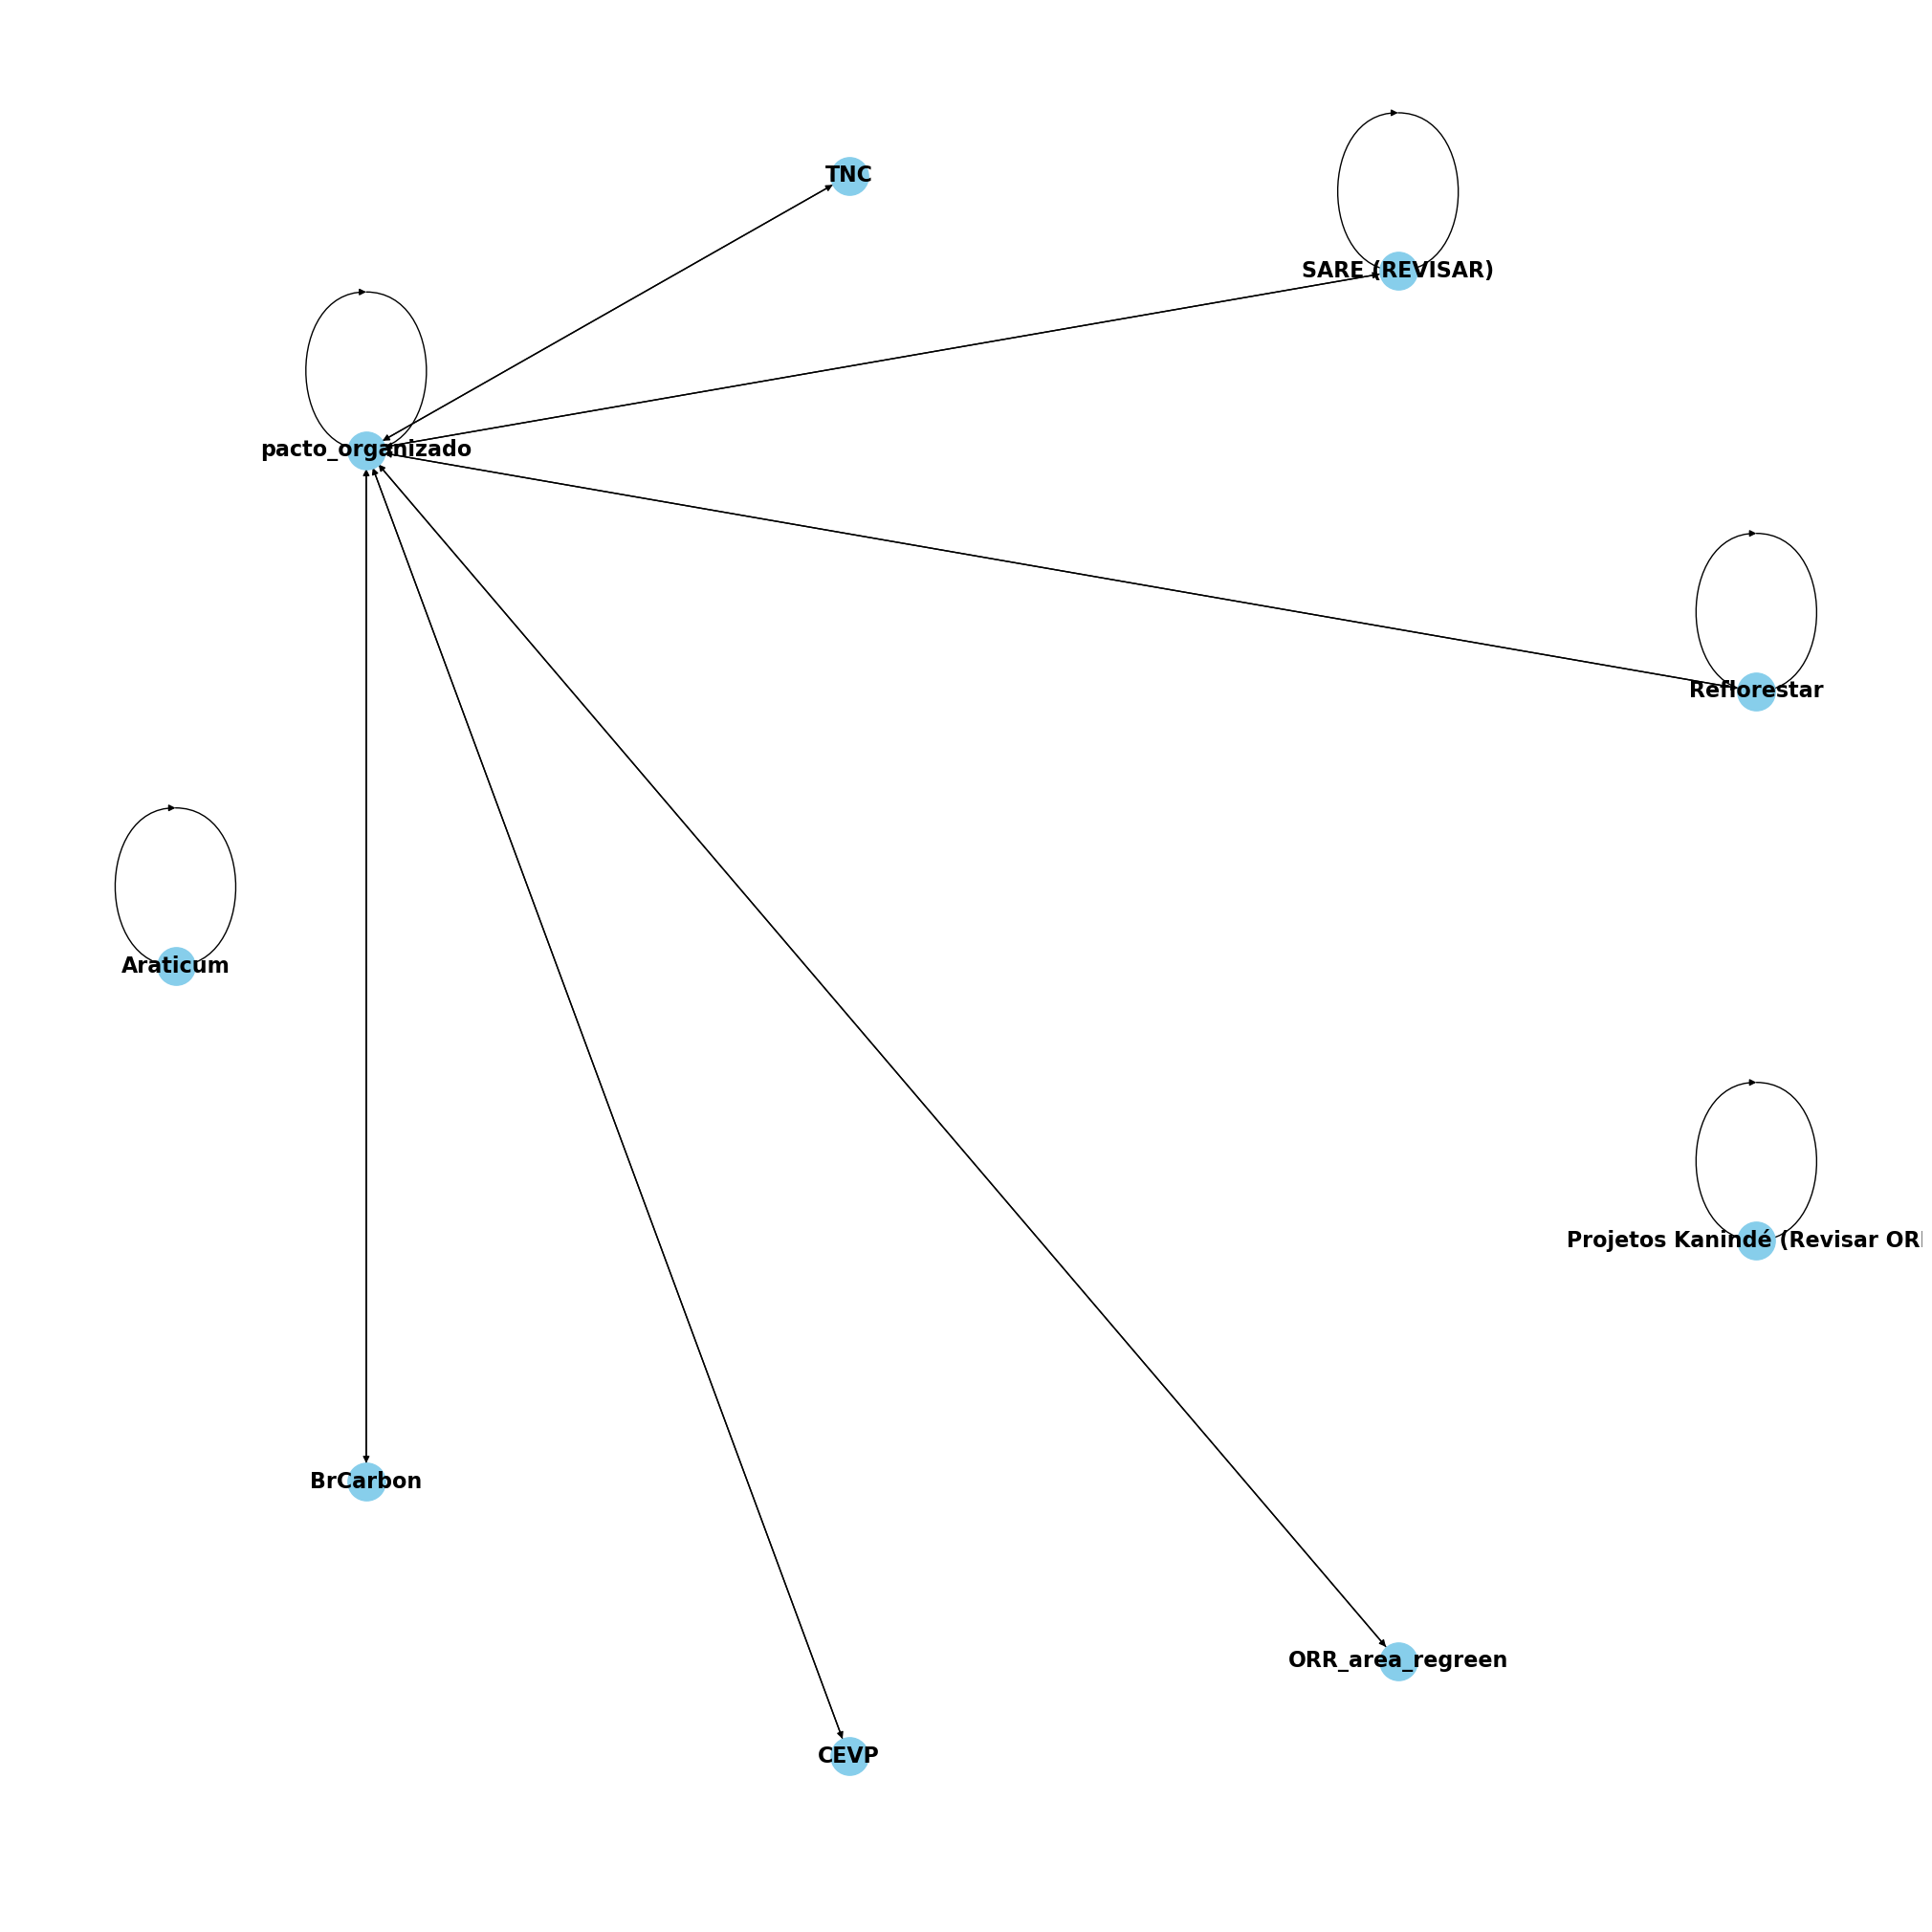

In [ ]:
for name in new.copy():
    _new[name]['indexs'] = set([get_id(i) for i in _new[name]['indexs']])

In [113]:
_new

{'Araticum/Araticum_ORR.shp': {'id': 0, 'indexs': {0}},
 'BrCarbon/Pratigi_Pai1_ORR.shp': {'id': 1, 'indexs': {1}},
 'BrCarbon/Pratigi_Pai2_ORR.shp': {'id': 2, 'indexs': {2}},
 'CEVP/Restauracao_CEVP.shp': {'id': 3, 'indexs': {3}},
 'ORR_area_regreen/MA_PAI_001.shp': {'id': 4, 'indexs': {4}},
 'ORR_area_regreen/MA_PAI_002.shp': {'id': 5, 'indexs': {5}},
 'Projetos Kanindé (Revisar ORR)/Dados recebidos/INICIATIVAS_EXECUTADAS_PELA_AGROFLORA.shp': {'id': 6,
  'indexs': {6}},
 'Projetos Kanindé (Revisar ORR)/Final/AGF Kaninde pol final.shp': {'id': 7,
  'indexs': {7}},
 'Reflorestar/Programa Reflorestar/Bacia do Doce.zip': {'id': 8,
  'indexs': {8}},
 'Reflorestar/Programa Reflorestar/Extenção Ambiental.zip': {'id': 9,
  'indexs': {9}},
 'Reflorestar/Reflorestar_shapefile/main_reflorestar_2021_revisado.shp': {'id': 10,
  'indexs': {10}},
 'SARE (REVISAR)/SARE_SHAPEFILE/Sare_Sirgas.shp': {'id': 11, 'indexs': {11}},
 'SARE (REVISAR)/sare.gpkg': {'id': 12, 'indexs': {12}},
 'TNC/Araucária e S